# Training GPT-2 model on Bangla books

Necessary imports for the project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from transformers import WEIGHTS_NAME, CONFIG_NAME
from tqdm import tqdm

2022-04-04 10:28:17.728338: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/anaconda/envs/Project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparing dataset
Initialize the project root, data, and model directories. `processed_data` directory contains selected books from renowned authors only.

In [2]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'processed_data/'
model_dir = project_root / 'models/bn_gpt2'
os.makedirs(model_dir, exist_ok=True) # Create if does not exist

Get list of files in the data directory

In [3]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [16]:
random.shuffle(filenames)
filenames = filenames[:100]

Split the files for training, validation, and testing. We are using 70% for training, 15% for validation and 15% for testing.

In [14]:
train_size = int(len(filenames) * 0.70)
train_filenames = filenames[:train_size]

validation_size = train_size + int(len(filenames) * 0.15)
validation_filenames = filenames[train_size:validation_size]

test_filenames = filenames[validation_size:]

`create_dataset` creates a Tensorflow Dataset from a list of filenames with a length of `max_sequence_length - 1`. `inputs` list contains first `max_sequence_length - 1` number of words except the last word, and `labels` list contains last `max_sequence_length - 1` words except the first word. `skip_size` defines how many words to skip from a tokenized string when creating `inputs` and `labels` list.

In [6]:
def create_dataset(tokenizer, filenames, max_sequence_length, skip_size):
    BATCH_SIZE = 12     # batch size 12 is needed for transformer
    BUFFER_SIZE = 1000  # for random shuffling
    inputs = []
    labels = []

    for file in tqdm(filenames):
        with open(file, 'r') as f:
            for line in f:
                string_tokenized = tokenizer.encode(line)
                for i in range(0, len(string_tokenized) - max_sequence_length + 1, skip_size):
                    ex = string_tokenized[i:i + max_sequence_length]
                    inputs.append(ex[:-1])
                    labels.append(ex[1:])
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    return dataset

Create a tokenizer from pretrained model and add special tokens for padding, beginning, and end of sentence.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("flax-community/gpt2-bengali")
tokenizer.add_special_tokens(
    {'pad_token': '<pad>', 'bos_token': '<s>', 'eos_token': '</s>'})

3

Define max sequence length and skip size for `create_dataset`.

In [8]:
MAX_SEQUENCE_LENGTH = 200
SKIP_SIZE = 50

Now we create train, validation and test dataset from the files.

In [15]:
train_dataset = create_dataset(tokenizer, train_filenames, MAX_SEQUENCE_LENGTH, SKIP_SIZE)
validation_dataset = create_dataset(tokenizer, validation_filenames, MAX_SEQUENCE_LENGTH, SKIP_SIZE)
test_dataset = create_dataset(tokenizer, test_filenames, MAX_SEQUENCE_LENGTH, SKIP_SIZE)

100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


## Creating Model

Load pretrained Bangla GPT2 model from [flax-community/gpt2-bengali](https://huggingface.co/flax-community/gpt2-bengali). Compile the pretrained model with optimizer `adam` with a learning_rate of 0.001, loss `sparse categorical crossentropy` and accuracy metric `sparse categorical accuracy`.

In [11]:
model = TFGPT2LMHeadModel.from_pretrained('flax-community/gpt2-bengali', from_pt=True)
# create model parameters
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(loss=[loss, *[None] * model.config.n_layer], optimizer=adam, metrics=[metric])

2022-04-04 10:32:19.187623: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-04-04 10:32:19.523735: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.6.attn.masked_bias', 'lm_head.weight', 'transformer.h.3.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another 

Create a checkpoint to save the best model that has the lowest loss.

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(str(model_dir),
                                                monitor='loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

Train on `train_dataset` for some epochs.

In [17]:
history = model.fit(train_dataset, validation_data=validation_dataset,
                    epochs=10, batch_size=1024, callbacks=[checkpoint])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

2022-04-04 10:36:11.858706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-04 10:36:11.914345: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2596990000 Hz


Training each epoch took around 30 minutes. Now we save the history for later use.

In [17]:
with open(str(model_dir / 'history'), 'wb') as file_pi:
    pickle.dump(history, file_pi)

INFO:tensorflow:Assets written to: ram://4025ca08-0081-4f7c-9472-1e172ec12420/assets


INFO:tensorflow:Assets written to: ram://4025ca08-0081-4f7c-9472-1e172ec12420/assets


And also save the model and tokenizer.

In [18]:
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(model_dir, WEIGHTS_NAME)
output_config_file = os.path.join(model_dir, CONFIG_NAME)
# save model and model configs
model.save_pretrained(model_dir)
model_to_save.config.to_json_file(output_config_file)
# save tokenizer
tokenizer.save_pretrained(model_dir)

('/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer_config.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/special_tokens_map.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/vocab.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/merges.txt',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/added_tokens.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer.json')

Finally we evaluate the model on `test_dataset`

In [19]:
model.evaluate(test_dataset, batch_size=1024)

457/457 [==============================] - 118s 256ms/step - loss: 1.8501 - logits_loss: 1.8501 - logits_accuracy: 0.5748 - past_key_values_1_accuracy: 1.1145e-04 - past_key_values_2_accuracy: 1.1756e-04 - past_key_values_3_accuracy: 1.6876e-05 - past_key_values_4_accuracy: 1.8300e-04 - past_key_values_5_accuracy: 1.4879e-04 - past_key_values_6_accuracy: 2.2984e-04 - past_key_values_7_accuracy: 1.1786e-04 - past_key_values_8_accuracy: 1.2130e-04 - past_key_values_9_accuracy: 8.9380e-05 - past_key_values_10_accuracy: 2.5103e-04 - past_key_values_11_accuracy: 9.1518e-05 - past_key_values_12_accuracy: 1.5982e-04


[1.8500999212265015,
 1.8500999212265015,
 0.5748472213745117,
 0.00011144801101181656,
 0.00011755684681702405,
 1.6875650544534437e-05,
 0.00018299771181773394,
 0.00014878825459163636,
 0.0002298448234796524,
 0.00011786228424170986,
 0.00012129850802011788,
 8.937985694501549e-05,
 0.00025103482767008245,
 9.151794802164659e-05,
 0.0001598223316250369]

The first value in the list is the loss, and the 3rd one is the accuracy.

## Plotting the training accuracy and loss

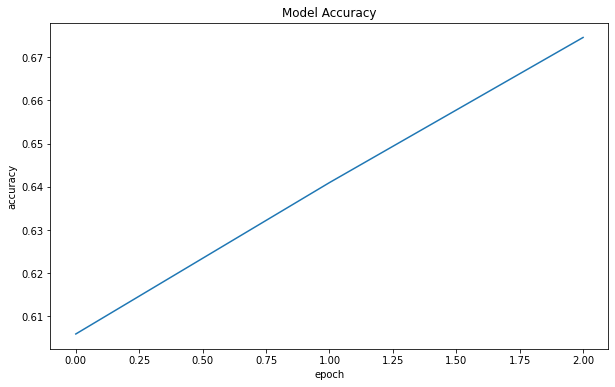

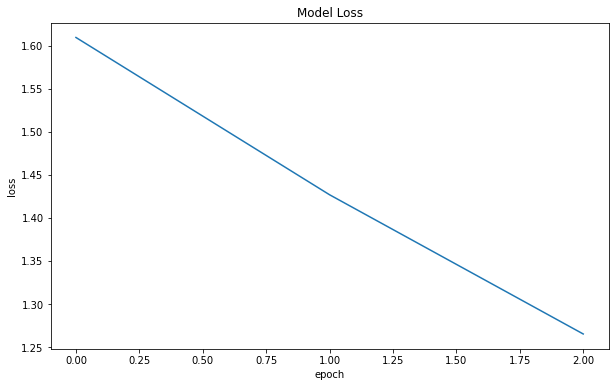

In [20]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
fig.savefig(str(model_dir / 'logits_accuracy.png'), dpi=fig.dpi)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
fig.savefig(str(model_dir / 'logits_loss.png'), dpi=fig.dpi)

## Testing the model with actual data

Load the tokenizer and the model first if not already loaded

In [21]:
tokenizer2 = AutoTokenizer.from_pretrained(model_dir)
model2 = TFGPT2LMHeadModel.from_pretrained(str(model_dir))

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /home/shafquat/bangla-next-word-prediction/models/bn_gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


The function `generate_text` takes as input text, model, and tokenizer and generates top 5 texts with sampling `top_k` of 50 and `top_p` of 0.95. More on these sampling can be found on this [blog post](https://huggingface.co/blog/how-to-generate).

In [78]:
def generate_text(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors='tf')
    outputs = model.predict(input_ids).logits

    print("Next most probable tokens:\n" + 100 * '-')
    for i in range(outputs.shape[1]):
        pred_id = np.argmax(outputs[:, i, :]).item()
        print(tokenizer.decode(pred_id))
    
    beam_outputs = model.generate(
        input_ids,
        max_length=100,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=5,
        early_stopping=True,
        do_sample=True,
        top_k=50,
        top_p=0.95,
    )

    print("Beam Output:\n" + 100 * '-')
    for i, beam_output in enumerate(beam_outputs):
        print("{}: {}".format(i, tokenizer.decode(
            beam_output, skip_special_tokens=True)))

Let's test our model for different texts using this function

In [77]:
text = input("Enter text: ")
generate_text(text, model, tokenizer)

Enter text: কী অবস্থা


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Next most probable tokens
:----------------------------------------------------------------------------------------------------
ে
র
্
থ
া
য
Beam Output:
----------------------------------------------------------------------------------------------------
0: কী অবস্থায় মারা গিয়েছিলেন সে সম্পর্কে কোনও বিশেষ কিছুই লেখেননি তিনি। অর্জুন জিজ্ঞেস করল, আপনি কী করে বেঁচে থাকা ব্যক্তিদের কথা লিখতে শুরু কর
1: কী অবস্থায় তিনি মৃত্যুবরণ করেছিলেন, তার সঠিক ইতিহাস কীভাবে জানা সম্ভব? কেউ কোনো কথা বলতে পারবে না। রিরা একটু অবাক হয়ে বলল, কিছুক্ষণ আগে তুমি আমাদের
2: কী অবস্থায় তিনি মৃত্যুবরণ করেছিলেন তার সঠিক ইতিহাস কীভাবে জানা সম্ভব? কেউ কি বলতে পারবে না যে তাঁর জীবনের সবচেয়ে বড় কৌতূহল কাকে দেখাতে চাচ্ছ
3: কী অবস্থায় তিনি মৃত্যুবরণ করেছিলেন তার সঠিক ইতিহাস কীভাবে জানা সম্ভব? কেউ কোনো কথা বলতে পারবে না। কাজেই আমি মনে করি আমাদের বাংলা ভাষাকে বাঁচিয়ে
4: কী অবস্থায় তিনি মৃত্যুবরণ করেছিলেন তার সঠিক ইতিহাস কীভাবে জানা সম্ভব? তাঁর জীবনের সবচেয়ে বড় অর্জন হচ্ছে কবিতা লেখা। পৃথিবীর যে কোনো ভাষাতেই


## Converting tensorflow model to tflite format

Set converter parameters to convert the model with FP16 quantization

In [80]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

Now convert the model and save as `.tflite` file

In [81]:
tflite_model = converter.convert()
# Save the model.
with open(model_dir / 'bn_gpt2_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp15gzj6_v/assets


INFO:tensorflow:Assets written to: /tmp/tmp15gzj6_v/assets
2022-04-02 16:36:19.172880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-02 16:36:19.172903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-02 16:36:19.173094: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp15gzj6_v
2022-04-02 16:36:19.225957: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-02 16:36:19.225987: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp15gzj6_v
2022-04-02 16:36:19.402393: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-02 16:36:20.635837: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp15gzj6_v
2022-04-02 16:36:21.010214: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

This model can be used with android applications